In [0]:
!nvidia-smi

Mon Feb 17 16:41:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Data From Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp "/content/drive/My Drive/Cancer_Detection/data.zip" "/content/data.zip" 
!unzip -qq "/content/data.zip"
!mv "/content/content/data" "/content/data"
!rm -r "/content/content"
!cp "/content/drive/My Drive/Cancer_Detection/train_labels.csv" "/content/data/input/train_labels.csv"
!mkdir "/content/data/working"
%cd "/content/data/working"

/content/data/working


# Data Exploration

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import keras,cv2,os
from random import shuffle

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras import layers,Input

from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import  preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imgaug import augmenters as iaa
import imgaug as ia

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc

Using TensorFlow backend.


In [0]:
path = "../input/" 
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
labels = pd.read_csv(path+"train_labels.csv")
df = df.merge(labels, on = "id") 
df.head(3)

,path,id,label
0,../input/train/1e6a4307eb6f15c3925b7d158d6c555...,1e6a4307eb6f15c3925b7d158d6c555a6c5f79d4,0
1,../input/train/cb49f02aa65e439b094ebb2071c7ab7...,cb49f02aa65e439b094ebb2071c7ab7e855ab1ba,0
2,../input/train/0014d82c35091030e1ef2e4cf9df5f1...,0014d82c35091030e1ef2e4cf9df5f1d35cd52af,0


In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [0]:
N = df["path"].size
X,y = load_data(N=N,df=df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
X.shape

(220025, 96, 96, 3)

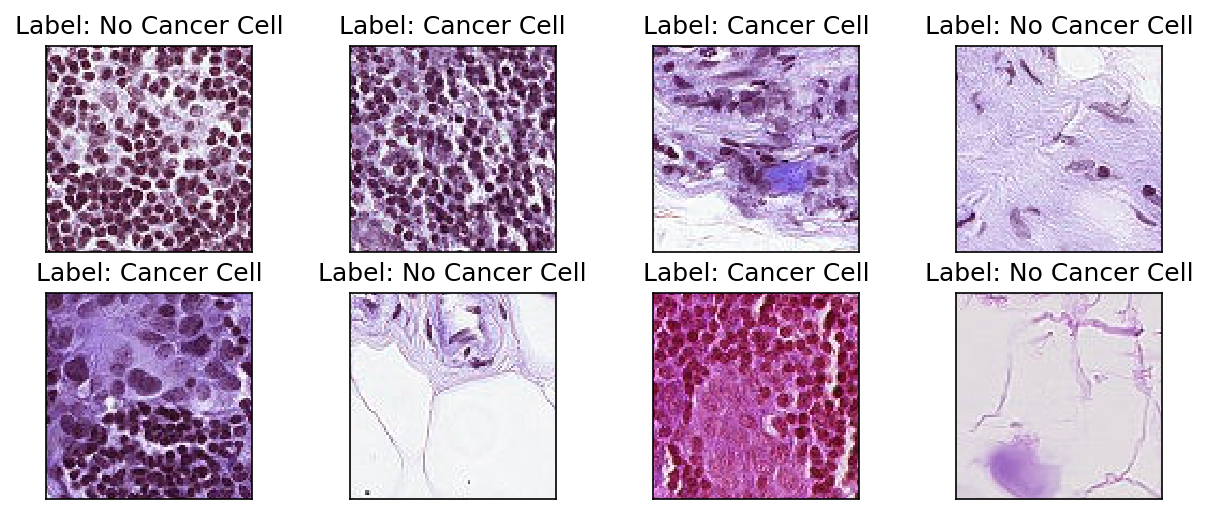

In [0]:
label = {0:"No Cancer Cell",1:"Cancer Cell"}
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100) 
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[])
    plt.imshow(X[idx])
    ax.set_title('Label: ' + label[y[idx]])

Text(0, 0.5, '# of samples')

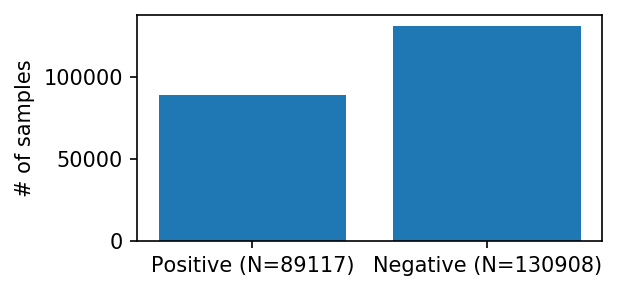

In [0]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]);
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

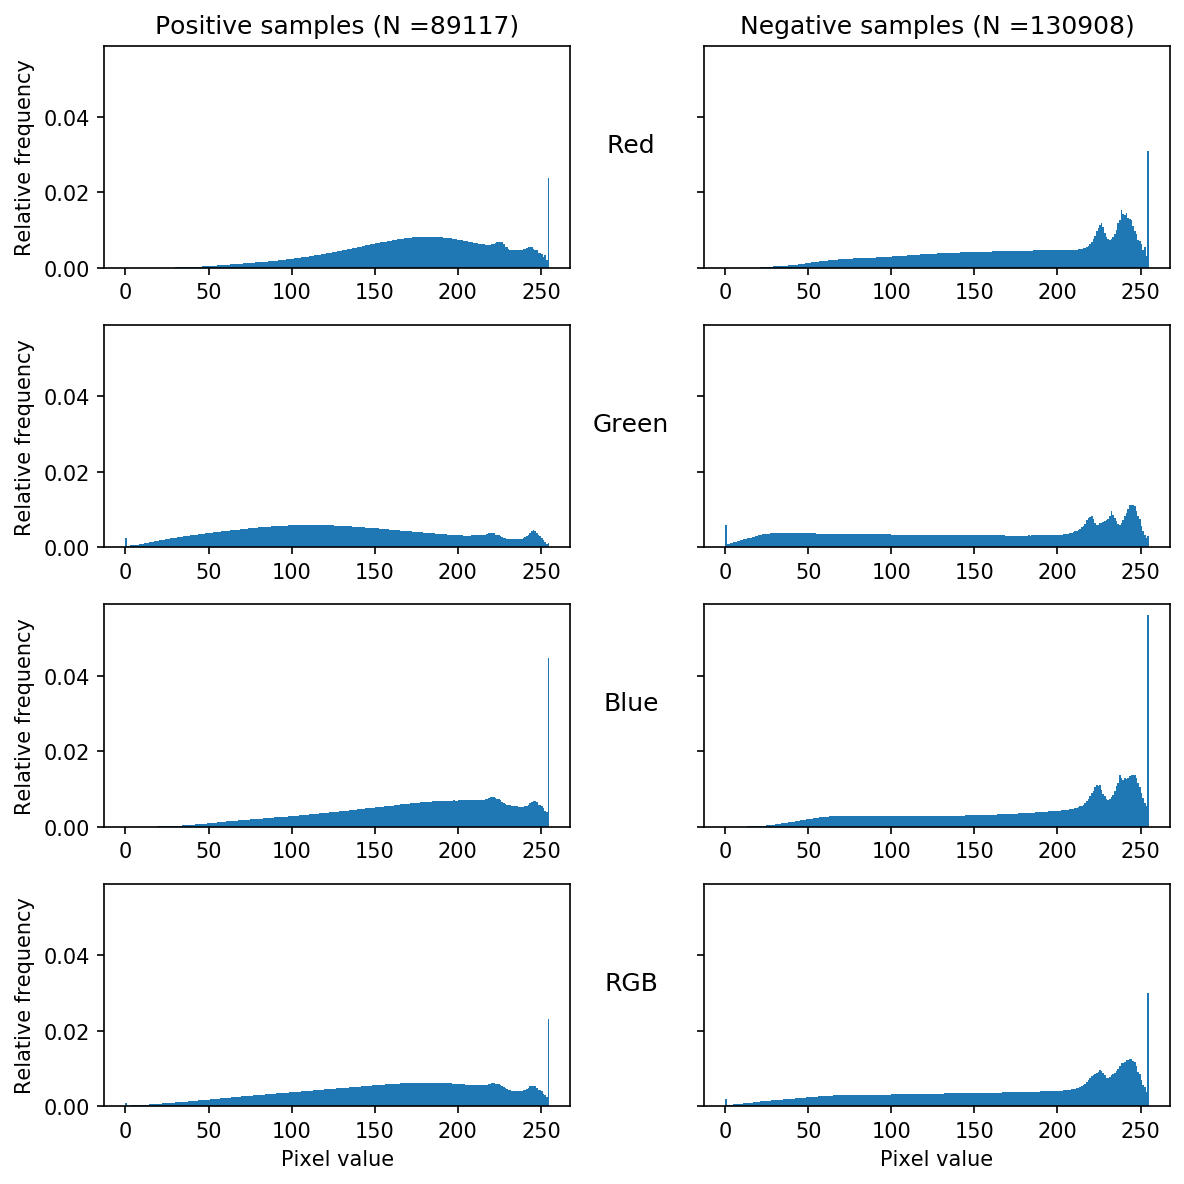

In [0]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()


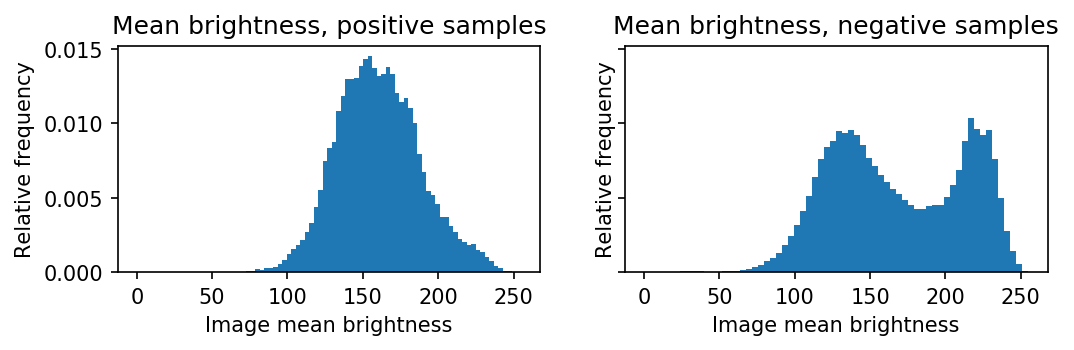

In [0]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

# Build Model

In [0]:
positives_samples = None
negative_samples = None
gc.collect();

In [0]:
training_portion = 0.8
split_idx = int(np.round(training_portion * y.shape[0]))

np.random.seed(42) #set the seed to ensure reproducibility

## Shuffle

In [0]:
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

## Architecture

In [0]:
def get_model_classif_nasnet_1():  
    
    #epoch = 15 --- 96.31%
    
    inputs = Input((96, 96, 3))

    x1 = layers.Conv2D(32,3,padding='same')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
#     x1 = layers.MaxPool2D(2,2)(x1)  

    
    x1_s = layers.SeparableConv2D(32,3,padding='same')(inputs)
    x1_s = layers.BatchNormalization()(x1_s)
    x1_s = layers.Activation('relu')(x1_s)
    x1_s = layers.SeparableConv2D(32,3,padding='same')(x1_s)
    x1_s = layers.BatchNormalization()(x1_s)
    x1_s = layers.Activation('relu')(x1_s)    
    x1_s = layers.SeparableConv2D(32,3,padding='same')(x1_s)
    x1_s = layers.BatchNormalization()(x1_s)
    x1_s = layers.Activation('relu')(x1_s)
    concetenated_0 = layers.concatenate([x1,x1_s])

    x2 = layers.Conv2D(64,3,padding='same')(concetenated_0)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64,3,padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64,3,padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    residual_concetenated_0 = layers.Conv2D(64,1,strides=1,padding='same')(concetenated_0)
    x2 = layers.add([x2,residual_concetenated_0])
    concetenates_x2_x1_s = layers.concatenate([x2,x1_s])
    x2 = layers.MaxPool2D(2,2)(concetenates_x2_x1_s)
    
    

    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2)
    x2_s = layers.BatchNormalization()(x2_s)
    x2_s = layers.Activation('relu')(x2_s)
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2_s)
    x2_s= layers.BatchNormalization()(x2_s)
    x2_s= layers.Activation('relu')(x2_s)
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2_s)
    x2_s= layers.BatchNormalization()(x2_s)
    x2_s= layers.Activation('relu')(x2_s)
    x2_s = layers.Conv2D(96,1,strides=1,padding='same')(x2_s)
    x2_s = layers.add([x2_s,x2]) 
    x2_s = layers.MaxPool2D(2,2)(x2_s)
    
    x3 = layers.Conv2D(128,3,padding='same')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    residual_x2 = layers.Conv2D(128,1,strides=1,padding='same')(x2)
    x3 = layers.add([residual_x2,x3]) 
    
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3_x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3_x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.add([x3,x3_x3]) 
    x3_x3 = layers.MaxPool2D(2,2)(x3_x3)
    
    
    concetenated_1 = layers.concatenate([x3_x3,x2_s])
    x3_s = layers.SeparableConv2D(128,3,padding='same')(concetenated_1)
    x3_s = layers.BatchNormalization()(x3_s)
    x3_s = layers.Activation('relu')(x3_s)
    x3_s = layers.SeparableConv2D(128,3,padding='same')(x3_s)
    x3_s= layers.BatchNormalization()(x3_s)
    x3_s= layers.Activation('relu')(x3_s)
    x3_s = layers.SeparableConv2D(128,3,padding='same')(x3_s)
    x3_s= layers.BatchNormalization()(x3_s)
    x3_s= layers.Activation('relu')(x3_s)
    x3_s = layers.add([x3_s,x3_x3]) 
    x3_s = layers.MaxPool2D(2,2)(x3_s)
    
    x4 = layers.Conv2D(256,3,padding='same')(x3_x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    residual_x3 = layers.Conv2D(256,1,strides=1,padding='same')(x3_x3)
    x4 = layers.add([residual_x3,x4]) 
    
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4_x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4_x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.add([x4,x4_x4]) 
    x4_x4 = layers.MaxPool2D(2,2)(x4_x4)
    

    concetenated_2 = layers.concatenate([x4_x4,x3_s])
    x4_s = layers.SeparableConv2D(256,3,padding='same')(concetenated_2)
    x4_s = layers.BatchNormalization()(x4_s)
    x4_s = layers.Activation('relu')(x4_s)
    x4_s = layers.SeparableConv2D(256,3,padding='same')(x4_s)
    x4_s= layers.BatchNormalization()(x4_s)
    x4_s= layers.Activation('relu')(x4_s)
    x4_s = layers.SeparableConv2D(256,3,padding='same')(x4_s)
    x4_s= layers.BatchNormalization()(x4_s)
    x4_s= layers.Activation('relu')(x4_s)
    x4_s = layers.add([x4_s,x4_x4]) 
    x4_s = layers.MaxPool2D(2,2)(x4_s)
    
    x5 = layers.Conv2D(512,3,padding='same')(x4_x4)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    residual_x4 = layers.Conv2D(512,1,strides=1,padding='same')(x4_x4)
    x5 = layers.add([residual_x4,x5])

    x5_x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.Conv2D(512,3,padding='same')(x5_x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.Conv2D(512,3,padding='same')(x5_x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.add([x5,x5_x5])
    x5_x5 = layers.MaxPool2D(2,2)(x5_x5)
    
    concetenated_3 = layers.concatenate([x5_x5,x4_s])
    x5_s = layers.SeparableConv2D(512,3,padding='same')(concetenated_3)
    x5_s = layers.BatchNormalization()(x5_s)
    x5_s = layers.Activation('relu')(x5_s)
    x5_s = layers.SeparableConv2D(512,3,padding='same')(x5_s)
    x5_s= layers.BatchNormalization()(x5_s)
    x5_s= layers.Activation('relu')(x5_s)
    x5_s = layers.SeparableConv2D(512,3,padding='same')(x5_s)
    x5_s= layers.BatchNormalization()(x5_s)
    x5_s= layers.Activation('relu')(x5_s)
    x5_s = layers.add([x5_s,x5_x5]) 

    x = layers.GlobalAveragePooling2D()(x5_s)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    output_tensor = layers.Dense(1,activation='sigmoid')(x)

    model = Model(inputs,output_tensor)
    
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

In [0]:
batch_size = 64
model = get_model_classif_nasnet_1()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 96, 96, 32)   155         input_1[0][0]                    
___________________________________________________________________

## Train & Validate

In [0]:
df_train = pd.read_csv("../input/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [0]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [0]:
labeled_files = glob('../input/train/*.tif')
test_files = glob('../input/test/*.tif')

train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)


In [0]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)


In [0]:
batch_size=128
path = "model.h5"
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

check_point = ModelCheckpoint('/content/drive/My Drive/Cancer_Detection/model.hdf5',monitor='val_loss',verbose=True, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=1)

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=25, verbose=1,
    callbacks=[checkpoint,early_stop,reduce_lr],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)



Epoch 1/25
1547/1547 [==============================] - 1935s 1s/step - loss: 0.4459 - acc: 0.7896 - val_loss: 0.3521 - val_acc: 0.8353

Epoch 00001: val_acc improved from -inf to 0.83525, saving model to model.h5
Epoch 2/25
1547/1547 [==============================] - 1785s 1s/step - loss: 0.3544 - acc: 0.8427 - val_loss: 0.5147 - val_acc: 0.8111

Epoch 00002: val_acc did not improve from 0.83525
Epoch 3/25
1547/1547 [==============================] - 1810s 1s/step - loss: 0.2827 - acc: 0.8817 - val_loss: 0.1668 - val_acc: 0.9374

Epoch 00003: val_acc improved from 0.83525 to 0.93742, saving model to model.h5
Epoch 4/25
1547/1547 [==============================] - 1793s 1s/step - loss: 0.2682 - acc: 0.8883 - val_loss: 0.1816 - val_acc: 0.9298

Epoch 00004: val_acc did not improve from 0.93742
Epoch 5/25
1547/1547 [==============================] - 1803s 1s/step - loss: 0.2455 - acc: 0.8995 - val_loss: 0.1369 - val_acc: 0.9507

Epoch 00005: val_acc improved from 0.93742 to 0.95067, s

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-772d3083b519>", line 15, in <module>
    validation_steps=len(val) // batch_size)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1658, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py", line 215, in fit_generator
    class_weight=class_weight)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1449, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2979, in __call__
    return self._call(inputs)
  File "/usr

KeyboardInterrupt: ignored

# Restart Training

In [0]:
model.load_weights("/content/drive/My Drive/Cancer_Detection/model.h5")

In [0]:
batch_size=128
path = '/content/drive/My Drive/Cancer_Detection/model_v2.h5'
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=25, verbose=1,
    callbacks=[checkpoint,early_stop,reduce_lr],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)

In [0]:
model.save_weights('/content/drive/My Drive/Cancer_Detection/model_v2.h5')
model.save('/content/drive/My Drive/Cancer_Detection/model_v2.keras')

# Inference

In [0]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/Cancer_Detection/model_v2.keras')

In [0]:
# model.load_weights("/content/drive/My Drive/Cancer_Detection/model_v2.h5")

In [0]:
preds = []
ids = []
from tqdm import tqdm
for batch in tqdm(chunker(test_files, batch_size)):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = model.predict(X)
    preds += list(preds_batch.reshape(-1))
    ids += ids_batch

3438it [07:38,  7.75it/s]


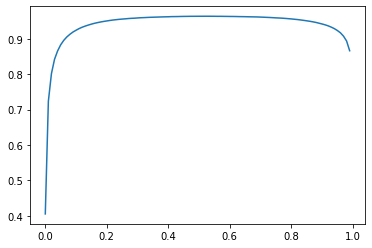

In [0]:
from sklearn.metrics import accuracy_score
S = []
for i in range(0,100):
  S.append(accuracy_score(y, np.array(preds)>=i/100))
plt.plot([i/100 for i in range(100)],S)

In [0]:
accuracy_score(y, np.array(preds)>=0.5)

0.9640995341438473

In [0]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
M = confusion_matrix(y, np.array(preds)>0.5)

In [0]:
plot_confusion_matrix(M,
                      normalize    = False,
                      target_names = ['No cancer', 'Cancer'],
                      title        = "Confusion Matrix")

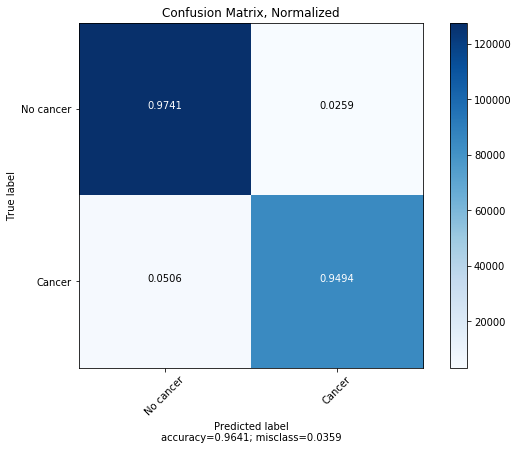

In [0]:
plot_confusion_matrix(M,
                      normalize    = True,
                      target_names = ['No cancer', 'Cancer'],
                      title        = "Confusion Matrix, Normalized")